# LAB 9: Transfer learning

Objectives:
- apply NLI + zero-shot learning 
- build a classifier using contextual word vectors
- fine tune distilbert for wine classification

**Important:** This notebook needs a GPU to work properly! If you're on google colab, choose Runtime > Change runtime type, and make sure Hardware Accelerator is set to GPU.

Set up transformers library

In [1]:
!pip -q install accelerate transformers datasets --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.3 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np

If you get an error here then double check that you've got the right kind of runtime (see comment above about GPUs)

In [3]:
DEVICE = 'cuda:0'
dev = torch.cuda.get_device_properties(0)
print(f"Using device: {dev.name} ({dev.total_memory/1024/1024/1024:.1f}gb)")

Using device: Tesla T4 (14.7gb)


---

## Load data

In [4]:
import torchtext
import datasets
from datasets import DatasetDict, Dataset

In [5]:
torchtext.utils.download_from_url('http://malouf.sdsu.edu/files/wine-data.tar.gz', root='./')
torchtext.utils.extract_archive('/content/wine-data.tar.gz', './')

100%|██████████| 14.6M/14.6M [00:01<00:00, 12.0MB/s]


['./wine-train.parquet', './wine-test.parquet']

In [6]:
ds = DatasetDict({'train':Dataset.from_parquet('wine-train.parquet'),
                  'test':Dataset.from_parquet('wine-test.parquet')}) \
                  .class_encode_column('wine_variant')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-1f610d2531230974/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-97f6351d1273668c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Casting to class labels:   0%|          | 0/130497 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/32625 [00:00<?, ? examples/s]

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['review_text', 'wine_variant'],
        num_rows: 130497
    })
    test: Dataset({
        features: ['review_text', 'wine_variant'],
        num_rows: 32625
    })
})

In [8]:
ds['train'].features

{'review_text': Value(dtype='string', id=None),
 'wine_variant': ClassLabel(names=['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir', 'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], id=None)}

---

## Fine-tuning

For this experiment, we will fine-tune the transformer model for our application (wine tasting notes). This entails retraining the entire model using small amount of task-specific training data.

Things to experiment with:
- Change the amount of training data, number of epochs, weight decay (similar to alpha for SGDClassifiers)
- Try a different model. Here is [a list of HuggingFace models that support text classification](https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads).

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

In [10]:
MODEL_CKPT = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

In [11]:
def tokenize(batch):
  return tokenizer(batch["review_text"], padding="max_length", truncation=True)

ds_tokenized = ds.map(tokenize, batched=True)

Map:   0%|          | 0/130497 [00:00<?, ? examples/s]

Map:   0%|          | 0/32625 [00:00<?, ? examples/s]

DistilBERT is picky: it expects the labels to be in a column called `label`.

In [12]:
ds_tokenized = ds_tokenized.rename_column('wine_variant','label')

In [13]:
ds_tokenized

DatasetDict({
    train: Dataset({
        features: ['review_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 130497
    })
    test: Dataset({
        features: ['review_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 32625
    })
})

Once we've created a dataset, we can save and/or reload it. This can save time if we have to re-run a notebook. Note though that once you close a Google Colab notebook, any saved files get thrown away. To preserve a saved dataset or model you need to download it to your own computer. 

In [14]:
#ds_tokenized.save_to_disk('ds_tokenized')
#ds_tokenized = datasets.load_from_disk('ds_tokenized')

To prep data for fine-tuning, we'll take a subset of the whole training set. We should start small and increase the training set size when we see how this works. We'll also reserve 10% of the training data as validation data to be used to test the model during training.

In [15]:
train = ds_tokenized['train'].select(range(1000)).train_test_split(test_size=0.1, stratify_by_column='label', seed=1)
train

DatasetDict({
    train: Dataset({
        features: ['review_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['review_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
})

And we'll take a subset of the test data (for demo purposes, so that model evaluation is faster)

In [15]:
test = ds_tokenized['test'].select(range(5000))

Load the model and train

In [17]:
labels = train['train'].features['label'].names
model = (AutoModelForSequenceClassification
             .from_pretrained(MODEL_CKPT, num_labels=len(labels))
             .to(DEVICE))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [18]:
BATCH_SIZE = 200
model_name = f"{MODEL_CKPT}-finetuned-wine"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  weight_decay=0.00001,
                                  logging_steps=10,
                                  evaluation_strategy="epoch",
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  auto_find_batch_size=True,
                                  fp16=True,
                                  disable_tqdm=False,
                                  log_level="error",
                                  optim="adamw_torch")

trainer = Trainer(model=model, 
                  args=training_args,
                  train_dataset=train["train"],
                  eval_dataset=train["test"],
                  tokenizer=tokenizer)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.816100,1.590869
2,1.093800,1.294082


TrainOutput(global_step=226, training_loss=1.5976809611362695, metrics={'train_runtime': 39.8144, 'train_samples_per_second': 45.21, 'train_steps_per_second': 5.676, 'total_flos': 238466831155200.0, 'train_loss': 1.5976809611362695, 'epoch': 2.0})

In [20]:
predicted = trainer.predict(test)
y_pred = np.argmax(predicted.predictions, axis=1)

In [21]:
print(classification_report(test['label'], y_pred, target_names=labels))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.54      0.67      0.60      1189
        Chardonnay       0.56      0.82      0.67       719
            Merlot       0.00      0.00      0.00       184
        Pinot Noir       0.56      0.80      0.66      1482
          Riesling       0.92      0.22      0.36       389
   Sauvignon Blanc       0.00      0.00      0.00       183
             Syrah       0.81      0.13      0.23       526
         Zinfandel       0.86      0.47      0.61       328

          accuracy                           0.58      5000
         macro avg       0.53      0.39      0.39      5000
      weighted avg       0.59      0.58      0.52      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


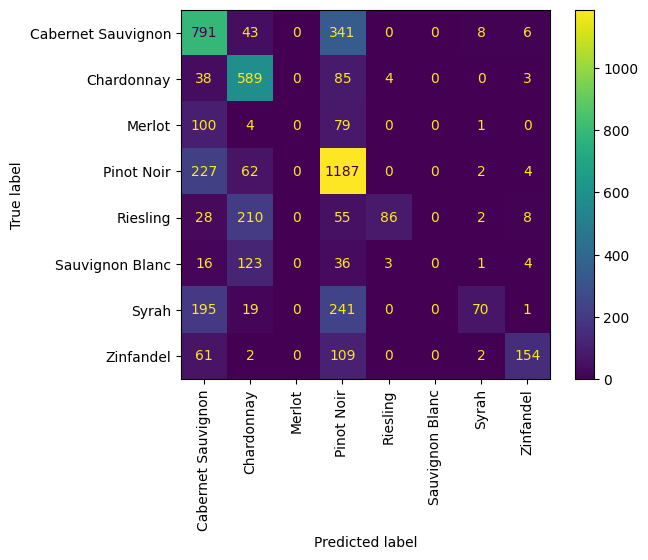

In [22]:
ConfusionMatrixDisplay.from_predictions(test['label'], 
                                        y_pred, 
                                        display_labels=labels, 
                                        xticks_rotation=90)


**Describe what you did and what you learned from these experiments:**

1. Changed Training data size
2. Changed weight decay and number of epochs

In [14]:
train = ds_tokenized['train'].select(range(5000)).train_test_split(test_size=0.1, stratify_by_column='label', seed=1)
train

DatasetDict({
    train: Dataset({
        features: ['review_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['review_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [16]:
labels = train['train'].features['label'].names
model = (AutoModelForSequenceClassification
             .from_pretrained(MODEL_CKPT, num_labels=len(labels))
             .to(DEVICE))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [18]:
BATCH_SIZE = 200
model_name = f"{MODEL_CKPT}-finetuned-wine"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4, ##
                                  weight_decay=0.001, ##
                                  logging_steps=10,
                                  evaluation_strategy="epoch",
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  auto_find_batch_size=True,
                                  fp16=True,
                                  disable_tqdm=False,
                                  log_level="error",
                                  optim="adamw_torch")

trainer = Trainer(model=model, 
                  args=training_args,
                  train_dataset=train["train"],
                  eval_dataset=train["test"],
                  tokenizer=tokenizer)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.929200,0.926652
2,0.710200,0.855745
3,0.654200,0.964209
4,0.547400,1.057133


TrainOutput(global_step=2252, training_loss=0.7860762750064925, metrics={'train_runtime': 411.3823, 'train_samples_per_second': 43.755, 'train_steps_per_second': 5.474, 'total_flos': 2384668311552000.0, 'train_loss': 0.7860762750064925, 'epoch': 4.0})

In [20]:
predicted = trainer.predict(test)
y_pred = np.argmax(predicted.predictions, axis=1)

In [21]:
print(classification_report(test['label'], y_pred, target_names=labels))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.68      0.74      0.71      1189
        Chardonnay       0.75      0.82      0.79       719
            Merlot       0.68      0.40      0.50       184
        Pinot Noir       0.74      0.80      0.77      1482
          Riesling       0.74      0.69      0.71       389
   Sauvignon Blanc       0.71      0.61      0.65       183
             Syrah       0.57      0.52      0.54       526
         Zinfandel       0.74      0.52      0.61       328

          accuracy                           0.71      5000
         macro avg       0.70      0.64      0.66      5000
      weighted avg       0.71      0.71      0.70      5000



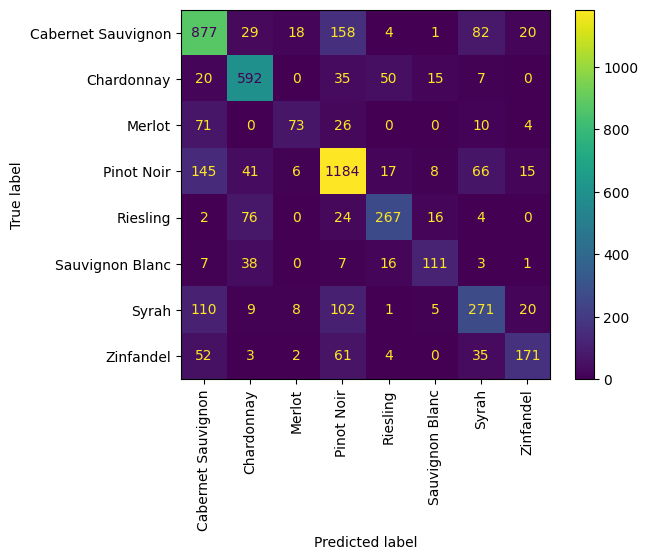

In [22]:
ConfusionMatrixDisplay.from_predictions(test['label'], 
                                        y_pred, 
                                        display_labels=labels, 
                                        xticks_rotation=90)

Improving the training data size and increasing number of epochs, pushed the accuracy an f1 macro up greatly.